# Preprocess COVID-19 flow cytometry data

In [1]:
import pytometry as pm
import scanpy as sc
import anndata as ann
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime

In [3]:
import os
import re

In [4]:
sc.logging.print_versions()
sc.settings.verbosity = 3 

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                         8.4.0
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi                        1.15.0
cftime                      1.5.1
charset_normalizer          2.0.7
cloudpickle 

Get date.

In [5]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

## Introduction

In this notebook, we preprocess COVID-19 FACS data, which have been collected in the [Georg et al. study](https://www.sciencedirect.com/science/article/pii/S0092867421015622?via%3Dihub) and were thankfully provided by Lorenzo Bonaguro via internal communication as FlowJo Workspace archive. 

We load the metadata, read the FCS files and transform them into the anndata format, normalize using the biexponential transformation (from FlowJo) as well as the arcsinh transformation and remove superfluous features. 

Set data path.

In [5]:
path_data = './../data/Bonaguro-COVID19/'

In [6]:
path_fcs = path_data + 'fcs_files/'

## Read metadata 

The metadata file was curated manually and contain information on all patient samples and their disease status. 

In [8]:
metadata = pd.read_excel(path_data + '200703_sample_anno.xlsx', index_col=0)

## Load flow data

Set path to flow data files.

In [7]:
fcs_files = os.listdir(path_fcs)

Read in all FCS files and add metadata info.

In [13]:
adata_tmp = pm.io.read_fcs(path_fcs +  fcs_files[0])

... storing 'marker' as categorical


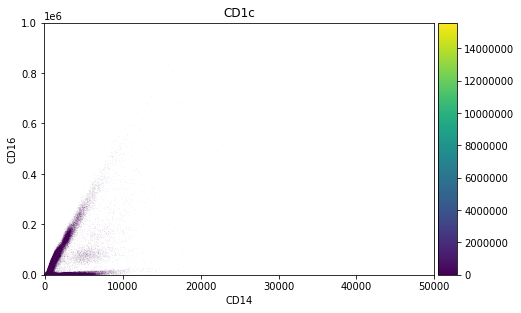

In [17]:
ax = sc.pl.scatter(adata_tmp, x= 'CD14', 
                   y='CD16', 
                   color='CD1c', show=False) #cd14 vs cd16
ax.set_xlim([-1e2, 5e4])
ax.set_ylim([-1e2, 1e6])
plt.show()

In [18]:
pm.pp.compensate(adata_tmp)

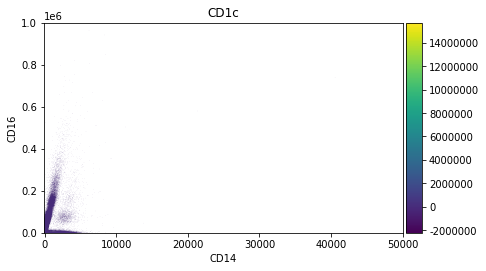

In [19]:
ax = sc.pl.scatter(adata_tmp, x= 'CD14', 
                   y='CD16', 
                   color='CD1c', show=False) #cd14 vs cd16
ax.set_xlim([-1e2, 5e4])
ax.set_ylim([-1e2, 1e6])
plt.show()

Read transformation and gate information from FlowJo files.

In [8]:
workspace_files = os.listdir(path_data)

workspace_params_files = [fileID for fileID in workspace_files 
                          if fileID.startswith('workspace_bonaguro_params')]
workspace_gate_files = [fileID for fileID in workspace_files 
                          if fileID.startswith('workspace_bonagure_gate')]

Import all data, run compensation, add metadata and transformation parameters, and concatenate the files.

In [113]:
adatas = list()
#iterate over all files
for fcs_file in fcs_files:
    if fcs_file.lower().endswith('.fcs'):
        print(fcs_file)
                    
        #read data
        adata_tmp = pm.io.read_fcs(path_fcs +  fcs_file)
        #run compensation
        pm.pp.compensate(adata_tmp)
                             
        #move Time, FSC, SSC to obs
        pm.pp.split_signal(adata_tmp, var_key ='channel')
        
        #add metadata
        sample_id = fcs_file
        adata_tmp.obs['sample'] = sample_id
        meta_row = metadata.loc[metadata.index==sample_id]
        for colname in meta_row.columns:
            adata_tmp.obs[colname] = meta_row[colname].values[0]
        
        #add gate info
        workspace_gate_file = [fileID for fileID in workspace_gate_files
                            if fileID.count(fcs_file.split('.fcs')[0])>0]
        gate_df = pd.read_csv(path_data + workspace_gate_file[-1], index_col=0)    
        

        for col in gate_df.columns[1:]:
            adata_tmp.obs['gate_' + col] = gate_df.loc[:,
                                            gate_df.columns==col].values.flatten()
        
        #add params for biex trafo
        workspace_param_file = [fileID for fileID in workspace_params_files
                                if fileID.count(fcs_file.split('.fcs')[0])>0]
        
        #add transformation info
        params = pd.read_csv(path_data + workspace_param_file[0], index_col = 0)
        rename_col = [idx.split('parameters.')[-1] for idx in params.columns.values]
        params.columns = rename_col
        #create new marker dictionary for renaming index in params data frame
        marker_dict_params = {}
        for key in adata_tmp.var['channel'].values:
            key_new = key.replace('/', '_')
            marker_dict_params[key_new] = adata_tmp.var.loc[adata_tmp.var['channel'] == key,
                                                            adata_tmp.var.columns == 'marker'
                                                           ].values[0][0]
        
        params.rename(index=marker_dict_params, inplace=True)
        #apply biex trafo
        pm.tl.normalize_biExp(adata_tmp, 
                              negative = params['neg'], 
                              positive = params['pos'], 
                              width = params['widthBasis'],
                              max_value = params['maxValue'] 
                             )
        
        
        #append data to 
        adatas.append(adata_tmp)

020620_COVID Fresh Ery lysis_3.fcs
020620_COVID Fresh Ery lysis_4.fcs
050620_COVID Fresh Ery lysis_10.fcs
050620_COVID Fresh Ery lysis_11.fcs
050620_COVID Fresh Ery lysis_12.fcs
050620_COVID Fresh Ery lysis_13.fcs
050620_COVID Fresh Ery lysis_14.fcs


/opt/python/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


050620_COVID Fresh Ery lysis_15.fcs
050620_COVID Fresh Ery lysis_16.fcs
050620_COVID Fresh Ery lysis_17.fcs
050620_COVID Fresh Ery lysis_18.fcs
090620_COVID Fresh Ery lysis_4.fcs
090620_COVID Fresh Ery lysis_5.fcs
090620_COVID Fresh Ery lysis_6.fcs
110520_COVID Fresh Ery lysis_3.fcs
110520_COVID Fresh Ery lysis_4.fcs
120520_COVID Fresh Ery lysis_Ctrl_10.fcs
120520_COVID Fresh Ery lysis_Ctrl_1.fcs
120520_COVID Fresh Ery lysis_Ctrl_2.fcs
120520_COVID Fresh Ery lysis_Ctrl_3.fcs
120520_COVID Fresh Ery lysis_Ctrl_4.fcs
120520_COVID Fresh Ery lysis_Ctrl_5.fcs
120520_COVID Fresh Ery lysis_Ctrl_6.fcs
120520_COVID Fresh Ery lysis_Ctrl_7.fcs
120520_COVID Fresh Ery lysis_Ctrl_8.fcs
120520_COVID Fresh Ery lysis_Ctrl_9.fcs
140520_COVID Fresh Ery lysis_1.fcs
140520_COVID Fresh Ery lysis_2.fcs
160620_COVID Fresh Ery lysis_3.fcs
160620_COVID Fresh Ery lysis_4.fcs
170620_COVID Fresh Ery lysis_1.fcs
170620_COVID Fresh Ery lysis_2.fcs
170620_COVID Fresh Ery lysis_3.fcs
170620_COVID Fresh Ery lysis_4.fcs


Check the number of files.

In [114]:
len(fcs_files)

55

In [115]:
len(adatas)

55

Check whether var_names and marker assignments are consistent.

In [116]:
print('1st element' + ' ' + 'n_vars')
for key in range(len(adatas)):
    print(adatas[key].var_names[0] + ' ' + str(adatas[key].n_vars))

1st element n_vars
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15
CD56 15


Let us check whether the data needs further normalisation.

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


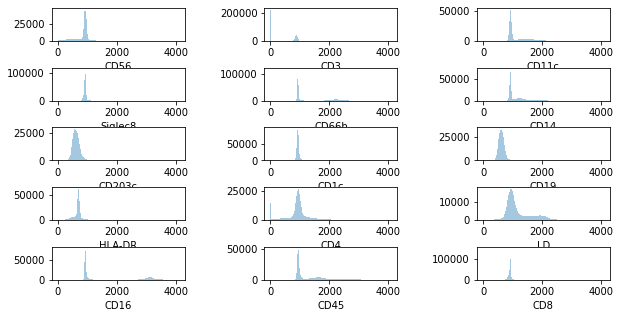

In [117]:
pm.pl.plotdata(adatas[1], figsize = (10,5))

... storing 'sample' as categorical
... storing 'donor_initials' as categorical
... storing 'status_max' as categorical
... storing 'status_exp_date' as categorical
... storing 'control' as categorical
... storing 'exclusion' as categorical
... storing 'time_point' as categorical
... storing 'merged_anno' as categorical
... storing 'bad_HLA-DR' as categorical


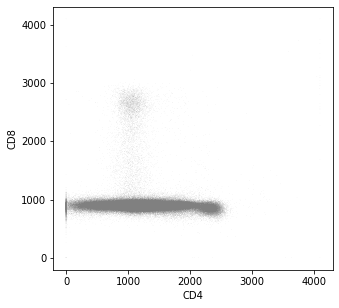

In [118]:
rcParams['figure.figsize']=(5,5)
ax = sc.pl.scatter(adatas[0], x='CD4', y = 'CD8', show=False)
#ax.set_xlim([-1e3, 1e4])
#ax.set_ylim([-1e3, 1e4])
plt.show()

## Concatenate data

In [119]:
adata = ann.AnnData.concatenate(*adatas,
                                batch_key='batch', 
                                join='outer', 
                                uns_merge= 'unique'
                               )  


/home/buettnerm/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [120]:
adata

AnnData object with n_obs × n_vars = 83456599 × 15
    obs: 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'sample', 'sample_ID', 'donor_initials', 'exp_date', 'status_max', 'status_exp_date', 'control', 'WHO_classification', 'WHO_max', 'days_post_symptoms', 'exclusion', 'time_point', 'merged_anno', 'total_wbc_count', 'comments', 'bad_HLA-DR', 'gate_root', 'gate_Cells', 'gate_Cells/Single Cells', 'gate_Single Cells/Single Cells', 'gate_live', 'gate_CD45+', 'gate_Granulocytes', 'gate_Eosinophils', 'gate_Neutrophils', 'gate_Q2: CD16+ , Siglec8+', 'gate_Q4: CD16- , Siglec8-', 'gate_PBMC', 'gate_B cells', 'gate_CD3+', 'gate_NKT', 'gate_CD3+/others', 'gate_CD4 T cells', 'gate_CD8 T cells', 'gate_PBMC/others', 'gate_NK cells', 'gate_others/others', 'gate_monocytes', 'gate_CD16 mono', 'gate_classical', 'gate_HLA-DR, CD11c subset', 'gate_intermediate', 'gate_Q4: CD16- , CD14-', 'batch'
    var: 'channel', 'marker', 'signal_type'
    uns: 'meta'
    layers: 'original'

Save data to file.

In [123]:
adata.obs.columns = [col.replace('/', '-') for col in adata.obs.columns] 

In [127]:
adata.obs['sample_ID'] = adata.obs['sample_ID'].astype(str)

In [128]:
#save to file
adata.write(path_data + 'H5AD/' + 'data_merged_facs_covid_lb.h5ad') 

... storing 'sample_ID' as categorical


In [8]:
adata = sc.read(path_data + 'H5AD/' + 'data_merged_facs_covid_lb.h5ad')

Check anndata size and feature names.

In [130]:
adata.var

,channel,marker,signal_type
CD56,YG E 586/15-A,CD56,area
CD3,YG D 610/20-A,CD3,area
CD11c,YG C 670/30-A,CD11c,area
Siglec8,YG A 780/60-A,Siglec8,area
CD66b,Blue E 530/30-A,CD66b,area
CD14,Blue B 710/50-A,CD14,area
CD203c,Red C 670/30-A,CD203c,area
CD1c,Red B 730/45-A,CD1c,area
CD19,Red A 780/60-A,CD19,area
HLA-DR,Vio H 431/28-A,HLA-DR,area


## Reduce to CD45+ cells

In the next step, we use the FlowJO gates to reduce the data to valid CD45+ cells (no debris, no doublets, no dead cells); only immune cells.

In [134]:
adata2 = adata[adata.obs['gate_CD45+']>0].copy()

In [135]:
adata2

AnnData object with n_obs × n_vars = 6424856 × 15
    obs: 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'sample', 'sample_ID', 'donor_initials', 'exp_date', 'status_max', 'status_exp_date', 'control', 'WHO_classification', 'WHO_max', 'days_post_symptoms', 'exclusion', 'time_point', 'merged_anno', 'total_wbc_count', 'comments', 'bad_HLA-DR', 'gate_root', 'gate_Cells', 'gate_Cells-Single Cells', 'gate_Single Cells-Single Cells', 'gate_live', 'gate_CD45+', 'gate_Granulocytes', 'gate_Eosinophils', 'gate_Neutrophils', 'gate_Q2: CD16+ , Siglec8+', 'gate_Q4: CD16- , Siglec8-', 'gate_PBMC', 'gate_B cells', 'gate_CD3+', 'gate_NKT', 'gate_CD3+-others', 'gate_CD4 T cells', 'gate_CD8 T cells', 'gate_PBMC-others', 'gate_NK cells', 'gate_others-others', 'gate_monocytes', 'gate_CD16 mono', 'gate_classical', 'gate_HLA-DR, CD11c subset', 'gate_intermediate', 'gate_Q4: CD16- , CD14-', 'batch'
    var: 'channel', 'marker', 'signal_type'
    uns: 'meta'
    layers: 'original'

In [138]:
#save to file
adata2.write(path_data + 'H5AD/' + 'data_cd45pos_facs_covid_lb.h5ad') 

Binarise disease severity.

In [7]:
adata2 = sc.read(path_data + 'H5AD/' + 'data_cd45pos_facs_covid_lb.h5ad') 

In [10]:
adata2.obs['covid_status'] = adata2.obs['status_exp_date'].cat.add_categories(['covid'])

In [11]:
adata2.obs['covid_status'][adata2.obs['covid_status'].isin(['mild', 'severe'])] = 'covid'
adata2.obs['covid_status'] = adata2.obs['covid_status'].cat.remove_unused_categories()

In [13]:
#save to file
adata2.write(path_data + 'H5AD/' + 'data_cd45pos_facs_covid_lb.h5ad') 

End of the pre-processing notebook.